In [23]:
import os
import cv2
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
SEED = 1000
IMG_SIZE = 256
BATCH_SIZE = 64

TRAIN_DIR = '/content/drive/MyDrive/Test'

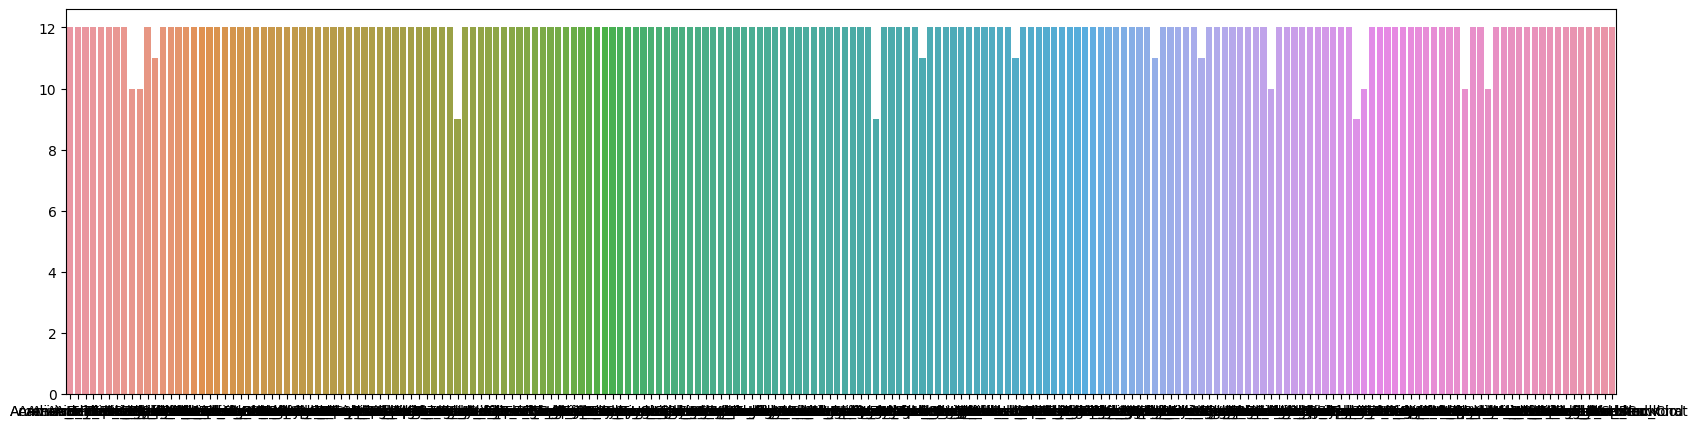

In [13]:
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(TRAIN_DIR):
  files = gb.glob(pathname=str(TRAIN_DIR + "//" + f + "/*"))
  class_names.append(f)
  class_count.append(len(files))
  train_examples += len(files)
plt.figure(figsize=(20,5))
sns.barplot(x=class_names, y=class_count)
plt.savefig('foo.png',dpi=1000)
plt.show()

In [14]:
train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

In [15]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode = 'categorical',
    seed=SEED
)

Found 1777 images belonging to 200 classes.


In [16]:
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode = 'categorical',
    seed=SEED
)

Found 597 images belonging to 200 classes.


In [17]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
base_model = tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=IMG_SHAPE)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()
base_model.trainable = False

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#x = tf.keras.layers.Dense(240, activation='relu')(x)
#x = tf.keras.layers.Dense(480, activation='relu')(x)
#x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

#x = tf.keras.layers.Dense(240, activation='relu')(x)
#x = tf.keras.layers.Dense(480, activation='relu')(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

#x = tf.keras.layers.Dense(32, activation='relu')(x)
#x = tf.keras.layers.Dense(64, activation='relu')(x)
#x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.4)(x)

#outputs = tf.keras.layers.Dense(50, activation='softmax')(x)
#outputs = tf.keras.layers.Dense(100, activation='softmax')(x)
#outputs = tf.keras.layers.Dense(150, activation='softmax')(x)
outputs = tf.keras.layers.Dense(200, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy']
)

cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_learning_rate=0.00001, verbose=2)

In [ ]:
resnet_model = model.fit(train_batch,
              epochs=20,
              steps_per_epoch = 1777 // BATCH_SIZE,
              validation_data = valid_batch,
              validation_steps = 597 // BATCH_SIZE,
              callbacks=[cb, reduce_lr]
             )

Epoch 1/20
27/27 [==============================] - 765s 28s/step - loss: 5.4821 - accuracy: 0.0111 - val_loss: 5.3424 - val_accuracy: 0.0052 - lr: 8.0000e-06
Epoch 2/20
27/27 [==============================] - 763s 28s/step - loss: 5.4697 - accuracy: 0.0134 - val_loss: 5.3460 - val_accuracy: 0.0017 - lr: 8.0000e-06
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 5.5218 - accuracy: 0.0140 
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
27/27 [==============================] - 757s 28s/step - loss: 5.5218 - accuracy: 0.0140 - val_loss: 5.3569 - val_accuracy: 0.0069 - lr: 8.0000e-06
Epoch 4/20
27/27 [==============================] - 743s 28s/step - loss: 5.4930 - accuracy: 0.0070 - val_loss: 5.3735 - val_accuracy: 0.0069 - lr: 1.6000e-06
Epoch 5/20
27/27 [==============================] - ETA: 0s - loss: 5.4996 - accuracy: 0.0169 
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
27/27 [=========================

In [ ]:
model.save("/content/drive/MyDrive/resnet_model.h5")

In [ ]:
print(h.history.keys())


In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],  label='train accuracy')
plt.plot(h.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'],  label='train loss')
plt.plot(h.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,10])
plt.legend(loc='upper right')
plt.savefig ("resnet.pdf",dpi=300)
plt.show()

In [24]:
model = tf.keras.models.load_model('/content/drive/MyDrive/resnet_model.h5')


10/10 [==============================] - 179s 17s/step


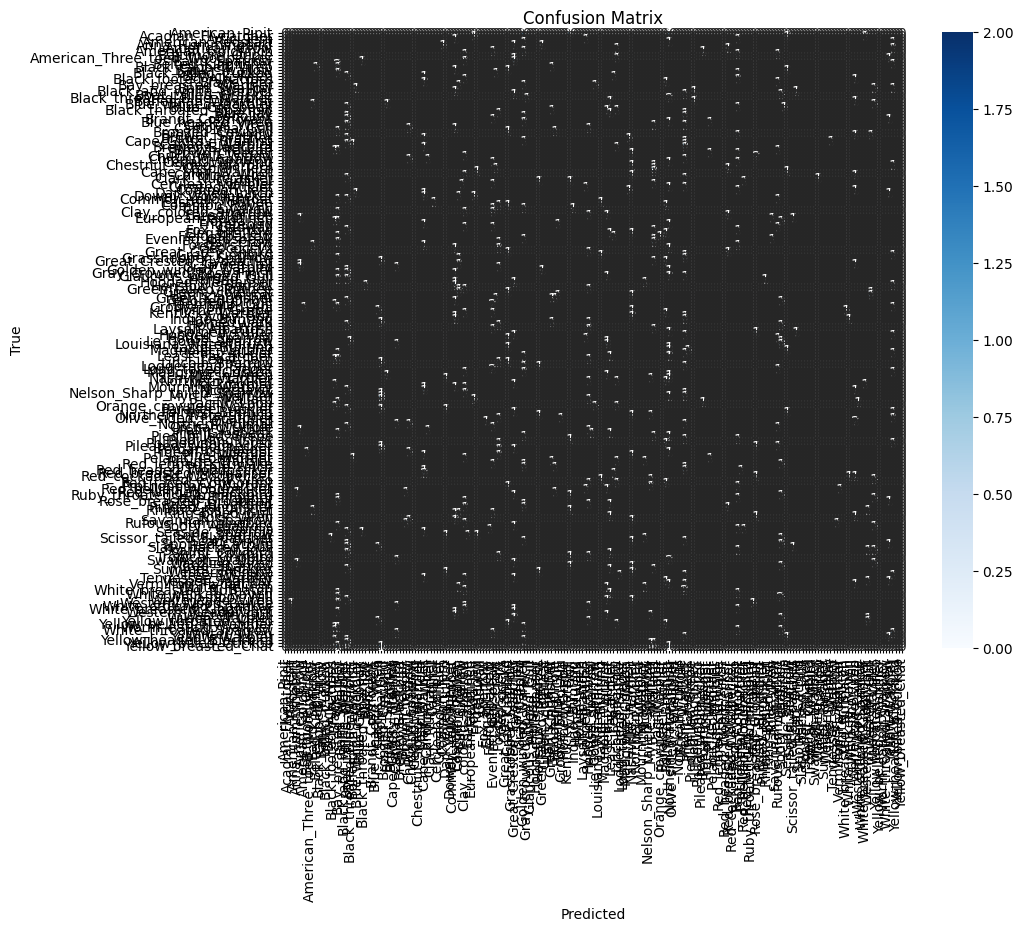

In [25]:
# Predict on validation data
y_pred = model.predict(valid_batch)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = valid_batch.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

In [27]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image

image_path = '/content/drive/MyDrive/Test/American_Pipit/American_Pipit_0001_100225.jpg'
preprocessed_image = preprocess_image(image_path)


In [11]:
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

predictions = model.predict(preprocessed_image)

1/1 [==============================] - 2s 2s/step


In [19]:
class_indices = train_batch.class_indices
class_mapping = {v: k for k, v in class_indices.items()}


In [21]:
predicted_class_index = np.argmax(predictions)
predicted_class_name = class_mapping[predicted_class_index]
print("Predicted class:", predicted_class_name)


Predicted class: Henslow_Sparrow
